<a href="https://colab.research.google.com/github/AgastyaPatel/cits4012-group/blob/main/MODEL_2_Cross_Attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%env PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True


env: PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Uncomment this if you have not downloaded glove in your colab notebook (or google drive)
!wget http://nlp.stanford.edu/data/glove.6B.zip -O glove.6B.zip
!unzip -q# glove.6B.zip -d glove


--2025-10-16 08:45:44--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2025-10-16 08:45:44--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2025-10-16 08:45:44--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [ ]:
import os
print("Current working directory:", os.getcwd())
!ls -lh


Current working directory: /content
total 823M
drwx------ 5 root root 4.0K Oct 16 08:45 drive
-rw-r--r-- 1 root root 823M Oct 25  2015 glove.6B.zip
drwxr-xr-x 1 root root 4.0K Oct 14 13:41 sample_data


In [ ]:
!ls -lh glove | grep 100d


-rw------- 1 root root 332M Aug  4  2014 glove.6B.100d.txt


In [ ]:
%cd /content/drive/MyDrive/DATASET/

/content/drive/MyDrive/DATASET


In [ ]:
!mkdir -p data models results utils

In [ ]:
import json
import pandas as pd
import re
import nltk
import matplotlib.pyplot as plt
from collections import Counter
import torch.nn.functional as F
from tqdm import tqdm
import seaborn as sns


nltk.download("punkt")
nltk.download("wordnet")
nltk.download("all")
# Download the missing resource for word_tokenize
nltk.download("punkt_tab")

from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_eng to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       tagg

# Dataset Description and Preprocessing.
The provided NLI dataset consists of premise–hypothesis–label triplets sourced from science exam questions.

After removing duplicates and null entries, we obtained N = X training samples, Y validation samples, and Z test samples.

Texts were normalised (lowercased, punctuation removed) and tokenised using NLTK. Each token was lemmatised via WordNetLemmatizer.

The final vocabulary contained V = {len(vocab)} unique tokens, with sentence lengths averaging A ± B tokens (see Figure 1). Class distribution was approximately balanced (Figure 2).

Train sample:
                                             premise  \
0  Pluto rotates once on its axis every 6.39 Eart...   
1  ---Glenn =====================================...   
2  geysers - periodic gush of hot water at the su...   
3  Facts: Liquid water droplets can be changed in...   
4  By comparison, the earth rotates on its axis o...   

                                          hypothesis    label  
0   Earth rotates on its axis once times in one day.  neutral  
1   Earth rotates on its axis once times in one day.  entails  
2  The surface of the sun is much hotter than alm...  neutral  
3  Evaporation is responsible for changing liquid...  entails  
4   Earth rotates on its axis once times in one day.  entails  

Tokenised example:
                                      premise_tokens  \
0  [pluto, rotates, once, on, it, axis, every, 63...   

                                   hypothesis_tokens  
0  [earth, rotates, on, it, axis, once, time, in,...  

Vocabulary size: 2011

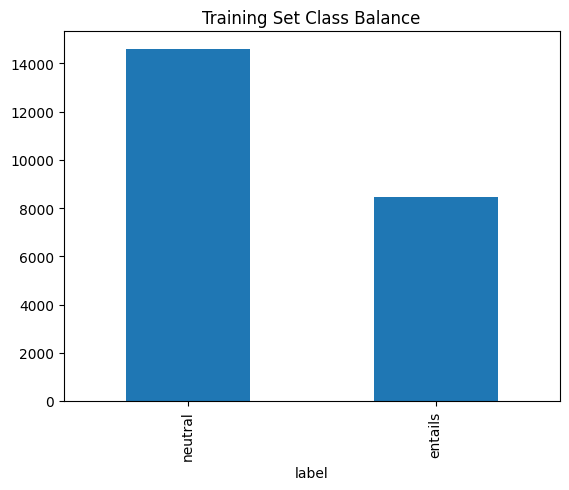

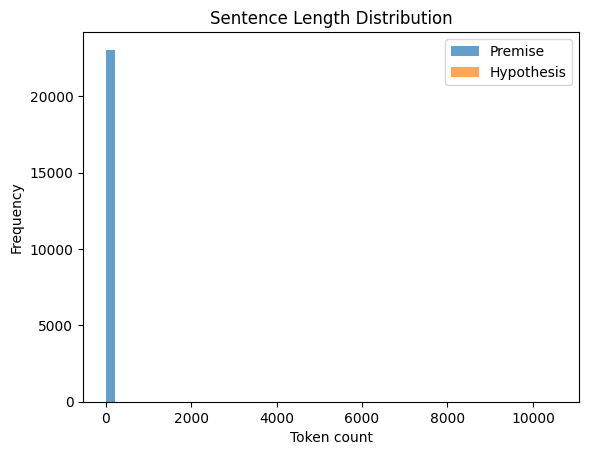

Average premise length: 18.01
Average hypothesis length: 11.74

 Preprocessing complete. Cleaned datasets saved to /data/


In [ ]:
from itertools import chain

# Step 1: Load datasets
def load_json_to_df(path):
    with open(path, "r") as f:
        data = json.load(f)
    return pd.DataFrame(data)

train_df = load_json_to_df("train_formatted.json")
val_df = load_json_to_df("validation_formatted.json")
test_df = load_json_to_df("test_formatted.json")

print("Train sample:")
print(train_df.head())

# Step 2: Clean and normalise text
def normalize_text(text):
    text = text.lower()
    text = re.sub(r"[^a-z0-9\s]", "", text)  # remove punctuation
    text = re.sub(r"\s+", " ", text).strip()
    return text

for df in [train_df, val_df, test_df]:
    df.dropna(subset=["premise", "hypothesis", "label"], inplace=True)
    df.drop_duplicates(inplace=True)
    df["premise"] = df["premise"].apply(normalize_text)
    df["hypothesis"] = df["hypothesis"].apply(normalize_text)

# Step 3: Tokenise and lemmatise
lemmatizer = WordNetLemmatizer()

def tokenize_and_lemmatize(text):
    tokens = word_tokenize(text, language='english')
    lemmas = [lemmatizer.lemmatize(tok) for tok in tokens]
    return lemmas

for df in [train_df, val_df, test_df]:
    df["premise_tokens"] = df["premise"].apply(tokenize_and_lemmatize)
    df["hypothesis_tokens"] = df["hypothesis"].apply(tokenize_and_lemmatize)

print("\nTokenised example:")
print(train_df[["premise_tokens", "hypothesis_tokens"]].head(1))

#  Step 4: Encode labels
label_map = {"entails": 1, "neutral": 0}
for df in [train_df, val_df, test_df]:
    df["label_id"] = df["label"].map(label_map)

# Step 5: Vocabulary construction
all_tokens = list(chain.from_iterable(train_df["premise_tokens"])) + \
             list(chain.from_iterable(train_df["hypothesis_tokens"]))
vocab = sorted(set(all_tokens))
print(f"\nVocabulary size: {len(vocab)}")

# Build word→index mapping
word2idx = {word: idx + 1 for idx, word in enumerate(vocab)}  # +1 reserve 0 for padding
idx2word = {idx: word for word, idx in word2idx.items()}

# Step 6: Exploratory analysis
label_counts = train_df["label"].value_counts()
print("\nClass distribution (train):")
print(label_counts)

label_counts.plot(kind="bar", title="Training Set Class Balance")
plt.show()

premise_lens = train_df["premise_tokens"].apply(len)
hypothesis_lens = train_df["hypothesis_tokens"].apply(len)

plt.hist(premise_lens, bins=50, alpha=0.7, label="Premise")
plt.hist(hypothesis_lens, bins=50, alpha=0.7, label="Hypothesis")
plt.legend()
plt.title("Sentence Length Distribution")
plt.xlabel("Token count")
plt.ylabel("Frequency")
plt.show()

print(f"Average premise length: {premise_lens.mean():.2f}")
print(f"Average hypothesis length: {hypothesis_lens.mean():.2f}")

# Step 7: Save processed files
train_df.to_csv("data/train_preprocessed.csv", index=False)
val_df.to_csv("data/val_preprocessed.csv", index=False)
test_df.to_csv("data/test_preprocessed.csv", index=False)

print("\n Preprocessing complete. Cleaned datasets saved to /data/")


In [ ]:
from collections import defaultdict
import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import numpy as np

# Step 1: Build vocabulary from training data

all_tokens = [tok for toks in train_df["premise_tokens"] for tok in toks] + \
             [tok for toks in train_df["hypothesis_tokens"] for tok in toks]

vocab = {"<pad>": 0, "<unk>": 1}
for tok in all_tokens:
    if tok not in vocab:
        vocab[tok] = len(vocab)

inv_vocab = {i: w for w, i in vocab.items()}
print(f" Vocabulary built. Size: {len(vocab)}")

# Step 2: Token → Index conversion function
def encode_tokens(tokens, vocab):
    return [vocab.get(tok, vocab["<unk>"]) for tok in tokens]

train_df["premise_ids"] = train_df["premise_tokens"].apply(lambda x: encode_tokens(x, vocab))
train_df["hypothesis_ids"] = train_df["hypothesis_tokens"].apply(lambda x: encode_tokens(x, vocab))
val_df["premise_ids"] = val_df["premise_tokens"].apply(lambda x: encode_tokens(x, vocab))
val_df["hypothesis_ids"] = val_df["hypothesis_tokens"].apply(lambda x: encode_tokens(x, vocab))
test_df["premise_ids"] = test_df["premise_tokens"].apply(lambda x: encode_tokens(x, vocab))
test_df["hypothesis_ids"] = test_df["hypothesis_tokens"].apply(lambda x: encode_tokens(x, vocab))

print("Sample encoded example:")
print(train_df[["premise_ids", "hypothesis_ids"]].head(1))

# Step 3: Custom Dataset class for PyTorch
class NLIDataset(Dataset):
    def __init__(self, dataframe):
        self.premises = dataframe["premise_ids"].tolist()
        self.hypotheses = dataframe["hypothesis_ids"].tolist()
        self.labels = dataframe["label_id"].tolist()

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        premise = torch.tensor(self.premises[idx], dtype=torch.long)
        hypothesis = torch.tensor(self.hypotheses[idx], dtype=torch.long)
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return premise, hypothesis, label

# Step 4: Collate function for dynamic padding
def collate_fn(batch):
    premises, hypotheses, labels = zip(*batch)
    premises_padded = pad_sequence(premises, batch_first=True, padding_value=vocab["<pad>"])
    hypotheses_padded = pad_sequence(hypotheses, batch_first=True, padding_value=vocab["<pad>"])
    labels = torch.stack(labels)
    return premises_padded, hypotheses_padded, labels

# Step 5: Create DataLoaders
MAX_LEN = 80  # cap sentence length for efficiency
def truncate_ids(ids): return ids[:MAX_LEN]
for df_ in [train_df, val_df, test_df]:
    df_["premise_ids"] = df_["premise_ids"].apply(truncate_ids)
    df_["hypothesis_ids"] = df_["hypothesis_ids"].apply(truncate_ids)

BATCH_SIZE = 16  # use smaller batch if you hit CUDA OOM


train_dataset = NLIDataset(train_df)
val_dataset = NLIDataset(val_df)
test_dataset = NLIDataset(test_df)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

print(f"DataLoaders ready. Train batches: {len(train_loader)}, Val batches: {len(val_loader)}")

# Step 6 (Optional): Quick sanity check
prem_batch, hyp_batch, lbl_batch = next(iter(train_loader))
print(f"\nPremise batch shape: {prem_batch.shape}")
print(f"Hypothesis batch shape: {hyp_batch.shape}")
print(f"Label batch shape: {lbl_batch.shape}")


 Vocabulary built. Size: 20118
Sample encoded example:
                        premise_ids                       hypothesis_ids
0  [2, 3, 4, 5, 6, 7, 8, 9, 10, 11]  [10, 3, 5, 6, 7, 4, 47, 75, 57, 11]
DataLoaders ready. Train batches: 1442, Val batches: 82

Premise batch shape: torch.Size([16, 34])
Hypothesis batch shape: torch.Size([16, 24])
Label batch shape: torch.Size([16])


In [ ]:
# Encode tokens and labels
def encode_tokens(tokens, vocab):
    return [vocab.get(tok, vocab["<unk>"]) for tok in tokens]

for df in [train_df, val_df, test_df]:
    df["premise_ids"] = df["premise_tokens"].apply(lambda t: encode_tokens(t, vocab))
    df["hypothesis_ids"] = df["hypothesis_tokens"].apply(lambda t: encode_tokens(t, vocab))
    df["label_id"] = df["label"].map(label_map)   # keep consistent mapping

#  Save vocab and labels
import json, os
os.makedirs("utils", exist_ok=True)

with open("utils/vocab.json", "w") as f:
    json.dump(vocab, f)
with open("utils/labels.json", "w") as f:
    json.dump(label_map, f)

print(" Saved vocab and label maps to utils/")


#  Sanity check
prem, hyp, lbl = next(iter(train_loader))
print(f"Premise batch: {prem.shape}, Hypothesis batch: {hyp.shape}, Labels: {lbl.shape}")


 Saved vocab and label maps to utils/
Premise batch: torch.Size([16, 31]), Hypothesis batch: torch.Size([16, 24]), Labels: torch.Size([16])


# Models

In [ ]:
import torch, random, numpy as np

SEED = 42
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


In [ ]:
import numpy as np
import torch.nn as nn

EMB_DIM = 100  # 50, 100, or 300 depending on GloVe file used
GLOVE_PATH = "/content/drive/MyDrive/DATASET/glove/glove.6B.100d.txt"


# 1. Load glove vectors
glove_vectors = {}
with open(GLOVE_PATH, "r", encoding="utf8") as f:
    for line in f:
        parts = line.strip().split()
        word = parts[0]
        vector = np.array(parts[1:], dtype=np.float32)
        glove_vectors[word] = vector

print(f"Loaded {len(glove_vectors):,} GloVe word vectors.")

# 2. Build embedding matrix for your vocab
embedding_matrix = np.zeros((len(vocab), EMB_DIM), dtype=np.float32)

for word, idx in vocab.items():
    if word in glove_vectors:
        embedding_matrix[idx] = glove_vectors[word]
    else:
        embedding_matrix[idx] = np.random.normal(scale=0.6, size=(EMB_DIM,))

embedding_matrix = torch.tensor(embedding_matrix)
print(f" Embedding matrix shape: {embedding_matrix.shape}")


Loaded 400,000 GloVe word vectors.
 Embedding matrix shape: torch.Size([20118, 100])


In [ ]:
embedding_layer = nn.Embedding.from_pretrained(
    embedding_matrix,
    freeze=False,            # False = fine-tune embeddings during training
    padding_idx=vocab["<pad>"]
)

print("Embedding layer ready.")


Embedding layer ready.


In [ ]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", DEVICE)

criterion = nn.CrossEntropyLoss()
def accuracy(preds, labels):
    _, predicted = torch.max(preds, 1)
    return (predicted == labels).float().mean()


Using device: cuda


In [ ]:
!mkdir -p models logs results


In [ ]:
for name, df in zip(["train", "val", "test"], [train_df, val_df, test_df]):
    print(name, "labels:", df["label_id"].unique())


train labels: [0 1]
val labels: [0 1]
test labels: [0 1]


# Model 2 – BiLSTM + Cross-Attention  
This model extends the baseline BiLSTM + Pooling by introducing *cross-attention* between the premise and the hypothesis.  
Instead of treating both sentences independently, the hypothesis learns to attend to informative tokens in the premise, enabling word-level alignment for Natural Language Inference.


In [ ]:
import gc, torch
gc.collect()
torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats()


### Cross-Attention Explanation
For each word in the hypothesis (`Q`), we compute similarity with every word in the premise (`K`).  
The softmax-normalised weights form an alignment matrix `α`, which is used to build a weighted context vector `C = α × V`.  
Thus each hypothesis token receives a contextualised representation of the premise.


In [ ]:
class CrossAttention(nn.Module):
    """
    Cross-Attention: lets the hypothesis attend to the premise.
    premise_enc: (B, Lp, D)
    hypo_enc:    (B, Lh, D)
    """
    def __init__(self, hidden_dim, dropout=0.1):
        super().__init__()
        self.scale = hidden_dim ** -0.5
        self.dropout = nn.Dropout(dropout)
        self.Wq = nn.Linear(hidden_dim, hidden_dim, bias=False)
        self.Wk = nn.Linear(hidden_dim, hidden_dim, bias=False)
        self.Wv = nn.Linear(hidden_dim, hidden_dim, bias=False)

    def forward(self, premise_enc, hypo_enc, mask=None):
        Q = self.Wq(hypo_enc)                     # (B, Lh, D)
        K = self.Wk(premise_enc)                  # (B, Lp, D)
        V = self.Wv(premise_enc)                  # (B, Lp, D)

        # scaled dot-product attention
        attn_logits = torch.matmul(Q, K.transpose(1, 2)) * self.scale  # (B, Lh, Lp)
        if mask is not None:
            attn_logits = attn_logits.masked_fill(mask == 0, -1e9)
        attn_weights = F.softmax(attn_logits, dim=-1)                  # (B, Lh, Lp)
        attn_weights = self.dropout(attn_weights)
        context = torch.matmul(attn_weights, V)                        # (B, Lh, D)
        return context, attn_weights


### Model Forward Flow
1. Encode premise and hypothesis separately with BiLSTMs.  
2. Compute cross-attention (`hypothesis → premise`).  
3. Pool both the hypothesis encoding and its attended context.  
4. Concatenate `[H, C, |H−C|, H⊙C]` and classify via MLP.


In [ ]:
class BiLSTMCrossAttention(nn.Module):
    def __init__(self, embedding_matrix, hidden_dim=128, num_classes=2, dropout=0.3):
        super().__init__()
        num_embeddings, embed_dim = embedding_matrix.size()
        self.embedding = nn.Embedding.from_pretrained(
            embedding_matrix, freeze=False, padding_idx=vocab["<pad>"]
        )
        self.bilstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.cross_attn = CrossAttention(hidden_dim*2, dropout=dropout)
        self.pool = nn.AdaptiveMaxPool1d(1)
        self.fc = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(hidden_dim*8, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def encode(self, x):
        H, _ = self.bilstm(self.embedding(x))       # (B, L, 2H)
        return H

    def forward(self, premise, hypothesis):
        P = self.encode(premise)                    # (B, Lp, 2H)
        H = self.encode(hypothesis)                 # (B, Lh, 2H)
        C, attn = self.cross_attn(P, H)             # (B, Lh, 2H)
        # Pool along sequence dimension
        H_pool = self.pool(H.transpose(1, 2)).squeeze(-1)
        C_pool = self.pool(C.transpose(1, 2)).squeeze(-1)
        diff = torch.abs(H_pool - C_pool)
        prod = H_pool * C_pool
        combined = torch.cat([H_pool, C_pool, diff, prod], dim=1)
        logits = self.fc(combined)
        return logits, attn


In [ ]:
model2 = BiLSTMCrossAttention(embedding_matrix, hidden_dim=128).to(DEVICE)
prem, hyp, lbl = next(iter(train_loader))
prem, hyp = prem.to(DEVICE), hyp.to(DEVICE)
with torch.no_grad():
    logits, attn = model2(prem, hyp)
print("logits:", logits.shape, "attention:", attn.shape)


logits: torch.Size([16, 2]) attention: torch.Size([16, 18, 26])


We verify that the model outputs:
- `logits`: (batch, num_classes)  
- `attention`: (batch, len_hypothesis, len_premise) — for later heat-map visualisation.


In [ ]:
logits, _ = model2(prem, hyp)


In [ ]:
prem, hyp, lbl = next(iter(train_loader))
prem, hyp = prem.to(DEVICE), hyp.to(DEVICE)
with torch.no_grad():
    logits, attn = model2(prem, hyp)
print("✓ Forward pass OK:", logits.shape, attn.shape)


✓ Forward pass OK: torch.Size([16, 2]) torch.Size([16, 20, 37])


### Cross-Attention Heatmap
Rows = hypothesis tokens.  
Columns = premise tokens.  
Brighter cells indicate stronger attention weights—i.e., which premise words each hypothesis word relied on for entailment reasoning.


In [ ]:
def visualize_cross_attention(model, premise, hypothesis, vocab):
    model.eval()
    prem_tokens = re.sub(r"[^a-z0-9\s]", "", premise.lower()).split()
    hyp_tokens  = re.sub(r"[^a-z0-9\s]", "", hypothesis.lower()).split()
    prem_ids = torch.tensor([[vocab.get(t, vocab["<unk>"]) for t in prem_tokens]]).to(DEVICE)
    hyp_ids  = torch.tensor([[vocab.get(t, vocab["<unk>"]) for t in hyp_tokens]]).to(DEVICE)
    with torch.no_grad():
        _, attn = model(prem_ids, hyp_ids)
    attn = attn.squeeze(0).cpu().numpy()
    plt.figure(figsize=(8,6))
    sns.heatmap(attn, xticklabels=prem_tokens, yticklabels=hyp_tokens, cmap="YlGnBu")
    plt.xlabel("Premise words"); plt.ylabel("Hypothesis words")
    plt.title("Cross-Attention Heatmap (Hypothesis → Premise)")
    plt.show()


## 7. Training and Validation Loop  
We reuse the same optimisation pipeline as the previous model but adapt it for the new output signature:  
`logits, attn = model2(premise, hypothesis)`.  
Only the logits are used for loss and accuracy; the attention matrix is saved later for visualisation.


In [ ]:

# Training + Validation for BiLSTM + Cross-Attention

model2 = BiLSTMCrossAttention(embedding_matrix, hidden_dim=128).to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model2.parameters(), lr=1e-3)
scaler = torch.cuda.amp.GradScaler()

EPOCHS = 5
train_losses, val_losses, train_accs, val_accs = [], [], [], []
best_val_acc = 0.0

def accuracy(preds, labels):
    return (preds.argmax(1) == labels).float().mean().item()

for epoch in range(EPOCHS):
    print(f"\n===== Epoch {epoch+1}/{EPOCHS} =====")
    # --------------------- TRAIN ---------------------
    model2.train()
    total_loss, total_acc, total_samples = 0, 0, 0
    for prem, hyp, lbl in tqdm(train_loader, desc="Training", leave=False):
        prem, hyp, lbl = prem.to(DEVICE), hyp.to(DEVICE), lbl.to(DEVICE)
        optimizer.zero_grad(set_to_none=True)
        with torch.cuda.amp.autocast():
            logits, _ = model2(prem, hyp)
            loss = criterion(logits, lbl)
        # Gradient clipping to stabilise training
        torch.nn.utils.clip_grad_norm_(model2.parameters(), max_norm=5)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item()
        total_acc += accuracy(logits, lbl) * lbl.size(0)
        total_samples += lbl.size(0)

    train_loss = total_loss / len(train_loader)
    train_acc = total_acc / total_samples
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # --------------------- VALIDATE ---------------------
    model2.eval()
    val_loss, val_acc, val_samples = 0, 0, 0
    with torch.no_grad(), torch.cuda.amp.autocast():
        for prem, hyp, lbl in tqdm(val_loader, desc="Validation", leave=False):
            prem, hyp, lbl = prem.to(DEVICE), hyp.to(DEVICE), lbl.to(DEVICE)
            logits, _ = model2(prem, hyp)
            loss = criterion(logits, lbl)
            val_loss += loss.item()
            val_acc += accuracy(logits, lbl) * lbl.size(0)
            val_samples += lbl.size(0)
    val_loss /= len(val_loader)
    val_acc /= val_samples
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    print(f"Train Loss={train_loss:.4f} Acc={train_acc:.3f} | Val Loss={val_loss:.4f} Acc={val_acc:.3f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model2.state_dict(), "models/bilstm_crossattn_best.pt")
        print(f"Saved new best model (Val Acc = {val_acc:.3f})")

torch.save(model2.state_dict(), "models/bilstm_crossattn_last.pt")
print(f"\nTraining complete. Best Val Acc = {best_val_acc:.3f}")


/tmp/ipython-input-4082061711.py:9: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()



===== Epoch 1/5 =====


Training:   0%|          | 0/1442 [00:00<?, ?it/s]/tmp/ipython-input-4082061711.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/tmp/ipython-input-4082061711.py:48: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast():


Train Loss=0.4874 Acc=0.761 | Val Loss=0.5434 Acc=0.716
💾 Saved new best model (Val Acc = 0.716)

===== Epoch 2/5 =====


Train Loss=0.3073 Acc=0.867 | Val Loss=0.5932 Acc=0.715

===== Epoch 3/5 =====


Train Loss=0.2081 Acc=0.916 | Val Loss=0.6713 Acc=0.732
💾 Saved new best model (Val Acc = 0.732)

===== Epoch 4/5 =====


Train Loss=0.1348 Acc=0.948 | Val Loss=0.9543 Acc=0.725

===== Epoch 5/5 =====


Train Loss=0.0921 Acc=0.965 | Val Loss=0.9134 Acc=0.719

✅ Training complete. Best Val Acc = 0.732


## 8. Training Curves  
Visualising loss and accuracy across epochs helps detect overfitting or underfitting.


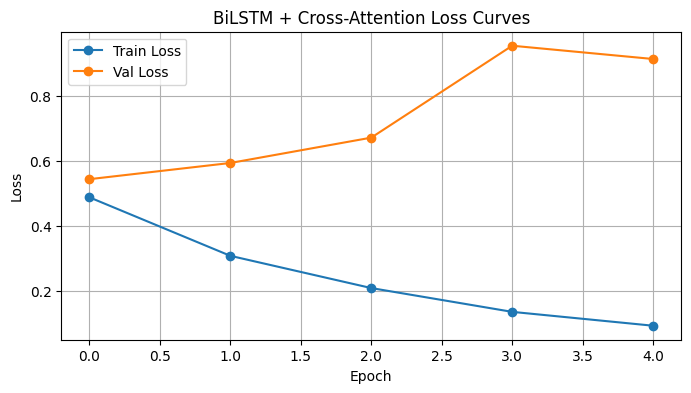

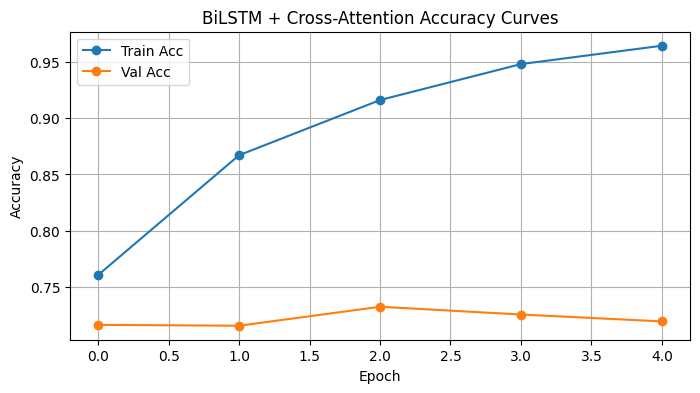

In [ ]:
plt.figure(figsize=(8,4))
plt.plot(train_losses, label="Train Loss", marker="o")
plt.plot(val_losses, label="Val Loss", marker="o")
plt.legend(); plt.title("BiLSTM + Cross-Attention Loss Curves")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.grid(True)
plt.show()

plt.figure(figsize=(8,4))
plt.plot(train_accs, label="Train Acc", marker="o")
plt.plot(val_accs, label="Val Acc", marker="o")
plt.legend(); plt.title("BiLSTM + Cross-Attention Accuracy Curves")
plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.grid(True)
plt.show()


## 9. Evaluation and Classification Reports  
We evaluate the best checkpoint on validation and test sets and produce confusion matrices and metrics.



Validation Classification Report:
              precision    recall  f1-score   support

     neutral       0.71      0.79      0.74       647
     entails       0.76      0.68      0.72       657

    accuracy                           0.73      1304
   macro avg       0.74      0.73      0.73      1304
weighted avg       0.74      0.73      0.73      1304



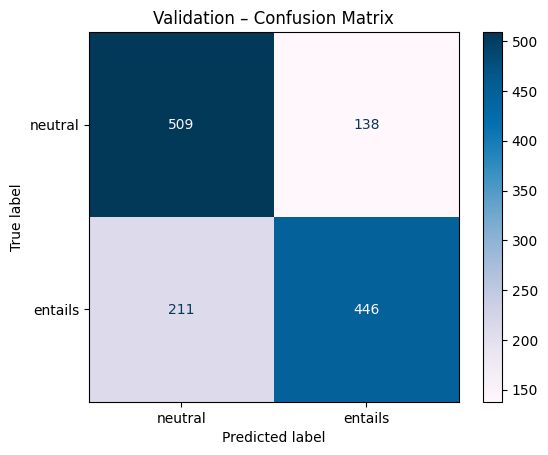


Test Classification Report:
              precision    recall  f1-score   support

     neutral       0.74      0.79      0.77      1284
     entails       0.65      0.58      0.61       842

    accuracy                           0.71      2126
   macro avg       0.69      0.68      0.69      2126
weighted avg       0.70      0.71      0.70      2126



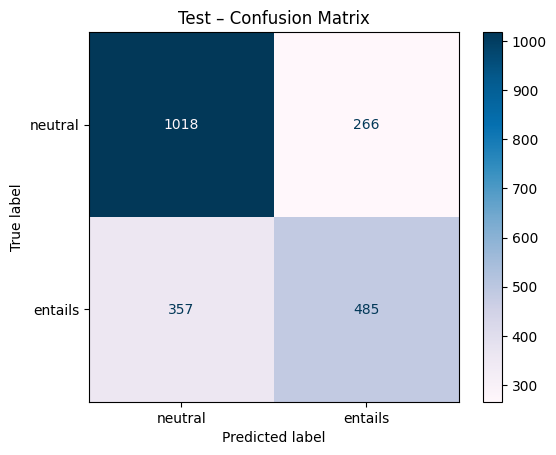

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

def evaluate_model(model, loader):
    model.eval()
    preds, labels_all = [], []
    with torch.no_grad():
        for prem, hyp, lbl in loader:
            prem, hyp, lbl = prem.to(DEVICE), hyp.to(DEVICE), lbl.to(DEVICE)
            logits, _ = model(prem, hyp)
            preds.extend(logits.argmax(1).cpu().numpy())
            labels_all.extend(lbl.cpu().numpy())
    return np.array(preds), np.array(labels_all)

# Load best checkpoint
best_model_path = "models/bilstm_crossattn_best.pt"
model2.load_state_dict(torch.load(best_model_path))

for name, loader in [("Validation", val_loader), ("Test", test_loader)]:
    preds, labels = evaluate_model(model2, loader)
    print(f"\n{name} Classification Report:")
    print(classification_report(labels, preds, target_names=["neutral","entails"]))
    cm = confusion_matrix(labels, preds)
    ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["neutral","entails"]).plot(cmap="PuBu")
    plt.title(f"{name} – Confusion Matrix")
    plt.show()


## 10. Attention Visualisation  
The cross-attention matrix (`len_hypothesis × len_premise`) shows which premise tokens each hypothesis token focused on.  
We use a heatmap to interpret the model’s reasoning.


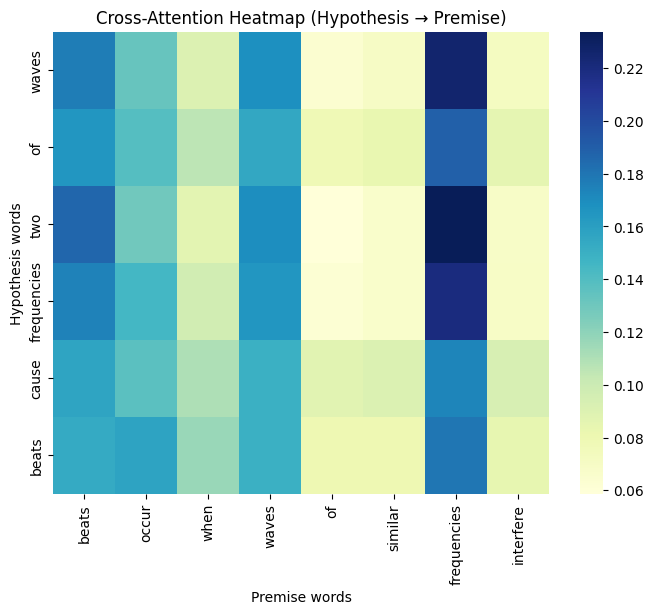

In [ ]:
visualize_cross_attention(
    model2,
    premise="Beats occur when waves of similar frequencies interfere.",
    hypothesis="Waves of two frequencies cause beats.",
    vocab=vocab
)


In [ ]:
import zipfile
best_path = "models/bilstm_crossattn_best.pt"
zip_path  = "models/bilstm_crossattn_best.zip"
with zipfile.ZipFile(zip_path, "w", zipfile.ZIP_DEFLATED) as zipf:
    zipf.write(best_path, arcname=os.path.basename(best_path))
print(f" Best model zipped for download → {zip_path}")
